## Libs


In [1]:
%load_ext autoreload
%autoreload 2
from typing import Optional, Tuple, Literal

import sys
import time
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import jax
import jax.numpy as jnp
import jax.random as jrandom 
import jax.nn as jnn
import equinox as eqx
import optax
from tqdm.notebook import tqdm
from collections import defaultdict
from functools import partial

jax.config.update('jax_enable_x64', True)
jax.config.update('jax_platforms', 'cpu')
# jax.config.update('jax_check_tracer_leaks', True) 
sys.path.append("../../..")
from lib.ml.icnn_modules import ProbStackedICNNImputer, ImputerMetrics, ProbICNNImputerTrainer
import lib.ehr.example_datasets.mimiciv_aki as m4aki
from lib.ehr.tvx_ehr import TVxEHR
from lib.utils import modified_environ, write_config
 

## Data Loading

### First Time Loading

In [2]:
# tvx = m4aki.TVxAKIMIMICIVDataset.load('/home/asem/GP/ehr-data/mimic4aki-cohort/tvx_aki.h5')

In [3]:
# obs = [adm.observables  for subject in tvx0.subjects.values() for adm in subject.admissions]
# adm_id = sum(([adm.admission_id] * len(adm.observables.time)  for subject in tvx0.subjects.values() for adm in subject.admissions), [])
# subj_id = sum(([subject.subject_id] * len(adm.observables.time)  for subject in tvx0.subjects.values() for adm in subject.admissions), [])

In [4]:
# obs_val = np.vstack([obs_i.value for obs_i in obs])
# obs_mask = np.vstack([obs_i.mask for obs_i in obs])
# obs_time = np.hstack([obs_i.time for obs_i in obs])

In [5]:
# tvx0.scheme.obs
# features = list(map(tvx0.scheme.obs.desc.get, tvx0.scheme.obs.codes))

In [6]:
# obs_val = pd.DataFrame(obs_val, columns=features)
# obs_mask = pd.DataFrame(obs_mask.astype(int), columns=features)
# meta = pd.DataFrame({'subject_id': subj_id, 'admission_id': adm_id, 'time': obs_time})


In [7]:
# artificial_mask = obs_mask.copy()
# artificial_mask = obs_mask & np.array(jrandom.bernoulli(jrandom.PRNGKey(0), p=0.75, shape=obs_mask.shape))


In [8]:
# obs_val.to_csv('missingness_data/missingness_vals.csv')
# obs_mask.to_csv('missingness_data/missingness_mask.csv')
# meta.to_csv('missingness_data/meta.csv')
# artificial_mask.to_csv('missingness_data/missingness_artificial_mask.csv')


### Later Loading

In [9]:
obs_val = pd.read_csv('missingness_data/missingness_vals.csv', index_col=[0])
obs_mask = pd.read_csv('missingness_data/missingness_mask.csv', index_col=[0])
artificial_mask = pd.read_csv('missingness_data/missingness_artificial_mask.csv', index_col=[0])
meta = pd.read_csv('missingness_data/meta.csv', index_col=[0])


### Split

In [10]:
split_ratio = 0.7
seed = 0
indices = jrandom.permutation(jrandom.PRNGKey(seed), len(obs_val))
train_idx = indices[:int(split_ratio * len(indices))]
test_idx = indices[int(split_ratio * len(indices)):]

obs_val_train = jnp.array(obs_val.iloc[train_idx].to_numpy())
obs_mask_train = jnp.array(obs_mask.iloc[train_idx].to_numpy())
art_mask_train =  jnp.array(artificial_mask.iloc[train_idx].to_numpy())

obs_val_test = jnp.array(obs_val.iloc[test_idx].to_numpy())
obs_mask_test = jnp.array(obs_mask.iloc[test_idx].to_numpy())
art_mask_test =  jnp.array(artificial_mask.iloc[test_idx].to_numpy())

## Model Configuration

In [11]:
# model = ICNNObsDecoder(observables_size=obs_mask.shape[1], state_size=0, 
#                        optax_optimiser_name='polyak_sgd',
#                        hidden_size_multiplier=2, depth=4, key=jrandom.PRNGKey(0))

model = ProbStackedICNNImputer(observables_size=obs_mask.shape[1],
                               state_size = 0,
                               positivity='abs',
                               optax_optimiser_name='polyak_sgd',
                               hidden_size_multiplier=2, depth=4, key=jrandom.PRNGKey(0))
trainer = ProbICNNImputerTrainer(loss='kl_divergence')

## Training

In [12]:
lr=1e-3
steps=10000
train_batch_size=256
test_batch_size=1024
# train_batch_size=1
# test_batch_size=1
eval_frequency = 10
model_snapshot_frequency = 100

optim = optax.novograd(lr)
opt_state = optim.init(eqx.filter(model, eqx.is_inexact_array))
data_train = (obs_val_train, obs_mask_train, art_mask_train)
data_test = (obs_val_test, obs_mask_test, art_mask_test)

In [13]:
train_batches = trainer.dataloader(data_train, train_batch_size, key=jrandom.PRNGKey(0))
test_batches = iter(trainer.dataloader(data_test, train_batch_size, key=jrandom.PRNGKey(0)))
train_history = defaultdict(list)
test_history = defaultdict(list)
model_snapshots = {}

In [14]:
progress = tqdm(range(steps))

for step, batch_train in zip(progress, train_batches):
    start = time.time()
    (train_loss, train_aux), model, opt_state = trainer.make_step(model, optim, opt_state, *batch_train)
    r2_vec =  trainer.model_r_squared(model, *batch_train)
    r2_vec_rank = trainer.model_r_squared_ranked_prob(model, *batch_train, k=5)
    r2_vec = np.array(r2_vec)
    train_nsteps = int(sum(train_aux.n_steps) / len(train_aux.n_steps))
    train_history['R2'].append(r2_vec)
    train_history['R2_rank5'].append(r2_vec_rank)
    train_history['loss'].append(train_loss)
    train_history['n_opt_steps'].append(train_nsteps)
    
    end = time.time()
    if (step % eval_frequency) == 0 or step == steps - 1:
        batch_test = next(test_batches)
        test_loss, _ = trainer.loss(model, *batch_test)
        r2_vec_test = trainer.model_r_squared(model, *batch_test)
        r2_vec_rank_test = trainer.model_r_squared_ranked_prob(model, *batch_test, k=10)
        r2_vec_test = np.array(r2_vec_test)
        test_history['loss'].append(test_loss)
        test_history['R2'].append(r2_vec_test)
        test_history['R2_rank10'].append(r2_vec_rank_test)

    if (step % model_snapshot_frequency) == 0 or step == steps - 1:
        model_snapshots[step] = model

    progress.set_description(f"Trn-L: {train_loss:.3f}, Trn-R2: ({np.nanmax(r2_vec_rank):.2f}, {np.nanmin(r2_vec_rank):.2f}, {np.nanmean(r2_vec_rank):.2f}, {np.nanmedian(r2_vec_rank):.2f}),  Trn-N-steps: {train_nsteps}, " 
                             f"Tst-L:  {test_loss:.3f}, Tst-R2:  ({np.nanmax(r2_vec_rank_test):.2f}, {np.nanmin(r2_vec_rank_test):.2f}, {np.nanmean(r2_vec_rank_test):.2f}, {np.nanmedian(r2_vec_rank_test):.2f}), "
                             f"Computation time: {end - start:.2f}, ")
                            

  0%|          | 0/10000 [00:00<?, ?it/s]

In [15]:
print('x')

x


In [19]:
train_stats = pd.DataFrame(train_history)
test_stats = pd.DataFrame(test_history)
train_stats['split'] = 'Train'
train_stats['iteration'] = train_stats.index + 1
test_stats['split'] = 'Test'
test_stats['iteration'] = (test_stats.index * eval_frequency) + 1
stats = pd.concat([train_stats, test_stats])
stats_melted = pd.melt(stats, value_vars=['loss'], id_vars=['split', 'iteration'], value_name='Loss')
stats_melted = stats_melted.astype({'Loss': float})

[(-10.0, 10000.0)]

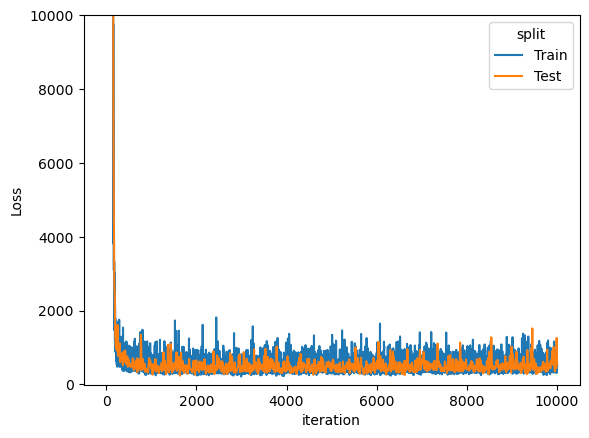

In [30]:
import seaborn as sns
g2 = sns.lineplot(data=stats_melted, x="iteration", y="Loss", hue="split")
g2.set(ylim=(-10., 10000.))


In [ ]:
dataframes = []
for step, model_snap in tqdm(model_snapshots.items()):
    with jax.default_device(jax.devices("cpu")[0]):
        obs_test = jnp.where(art_mask_test, obs_val_test, 0.)
        (X_test_imp, X_test_std), _ = eqx.filter_vmap(model_snap.prob_partial_input_optimise)(obs_test, art_mask_test)
    
    sigma_threshold = [4.0, 3.0, 2.5, 2.0, 1.5, 1.0, 0.5, 0.3, 0.2, 0.1, 0.05, 0.01]
    predicted_mask = (1 - art_mask_test) * obs_mask_test
    r2_vec_thresholded = [eqx.filter_vmap(ProbICNNImputerTrainer.r_squared_thresholded_prob)(obs_val_test.T, X_test_imp.T, predicted_mask.T, X_test_std.T,  t)
                          for t in sigma_threshold]
    
    r2_test_results = pd.DataFrame(np.vstack(r2_vec_thresholded), columns=obs_val.columns)
    r2_test_results['sigma_threshold'] = sigma_threshold
    r2_test_results['step'] = step
    dataframes.append(r2_test_results)

r2_test_results = pd.concat(dataframes)
r2_test_results = pd.melt(r2_test_results, value_vars=list(obs_val.columns), id_vars=['sigma_threshold'], value_name='R2')

  0%|          | 0/101 [00:00<?, ?it/s]